In [ ]:
import base64

from PIL import Image

from IPython.display import display, Markdown, HTML

import numpy as np

import tifffile

import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms

import io
import imageio.v2 as imageio

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tqdm.notebook import tqdm
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
choosed = 'TCGA_CS_4941_19960909'

# **DataSet**

In [ ]:
# =======================
#  1. Monter Google Drive
# =======================
from google.colab import drive
drive.mount('/content/drive')

# =======================
#  2. Décompresser TCGA.zip
# =======================
import zipfile
import os

zip_path = "/content/drive/MyDrive/TCGA.zip"
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extrait !")
else:
    print("Dataset déjà extrait.")
zip_path = "/content/drive/MyDrive/chekpoints.zip"
extract_path = "/content/checkpoints"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("chekpoints extrait !")
else:
    print("chekpoints déjà extrait.")


Mounted at /content/drive
Dataset extrait !
chekpoints extrait !


In [ ]:
DATASET_DIR = "/content/dataset/lgg-mri-segmentation/kaggle_3m"
#DATASET_DIR = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [ ]:
def overlay_images(image1, image2):
    if isinstance(image1, str):
        img1 = Image.open(image1)
    else:
        img1 = transforms.ToPILImage()(image1)
    if isinstance(image2, str):
        img2 = Image.open(image2)
    elif isinstance(item, Image.Image):
        pass
    else:
        img2 = transforms.ToPILImage()(image2)

    img2 = img2.resize(img1.size)

    combined_image = Image.new('RGB', img1.size)
    combined_image.paste(img1, (0, 0))
    combined_image.paste(img2, (0, 0), img2)

    return combined_image

def create_gif(image_paths_or_images, duration=0.5):
    images = []
    for item in image_paths_or_images:
        if isinstance(item, str):
            images.append(imageio.imread(item))
        elif isinstance(item, Image.Image):
            img_array = np.array(item)
            images.append(img_array)

    with io.BytesIO() as gif_io:
        imageio.mimsave(gif_io, images, format='GIF', duration=duration, loop=0)
        gif_io.seek(0)
        return gif_io.read()

def show_gif_list(list, labels, duration=0.5):
    list_gif = [f"""
    <div style="display: flex; flex-direction: column; align-items: center; text-align: center; margin: 10px;">
        <div>{labels[i]}</div>
        <img src="data:image/gif;base64,{base64.b64encode(create_gif(list[i], duration)).decode('utf-8')}" />
    </div>
    """ for i in range(len(list))]

    # Exibir os GIFs diretamente lado a lado usando HTML
    html = f"""
    <div style="display: flex; justify-content: center; flex-wrap: wrap;">
        {"".join(list_gif)}
    </div>
    """

    display(HTML(html))


def show_metadata_mri_tiff(file_path):
    with tifffile.TiffFile(file_path) as tif:
        print("File name:", file_path)
        print("Number of pages (slices):", len(tif.pages))
        print("Data format:", tif.series[0].dtype)
        print("Dimensions (h, w, slices):", tif.series[0].shape)

        # Volumetric image? (3D)
        if len(tif.series[0].shape) == 3:
            print("Volumetric image detected (3D).")

        # Tags TIFF for MRI
        print("\nTags TIFF:")
        for tag in tif.pages[0].tags.values():
            print(f"{tag.name}: {tag.value}")

        # Show informations about spatial resolutions if provided
        x_resolution = tif.pages[0].tags.get('XResolution')
        y_resolution = tif.pages[0].tags.get('YResolution')
        resolution_unit = tif.pages[0].tags.get('ResolutionUnit')

        if x_resolution and y_resolution and resolution_unit:
            print(f"Spatial Resolutions: {x_resolution.value[0]}/{x_resolution.value[1]} {resolution_unit.value}")

        # Estats image
        img_data = tif.asarray()
        print("\nEstats img MRI:")
        print(f"Min value: {np.min(img_data)}")
        print(f"Max value: {np.max(img_data)}")
        print(f"Mean: {np.mean(img_data)}")
        print(f"STD: {np.std(img_data)}")

def plot_error_distribution(title="Distribution of Segmentation Errors", xlabel="Mean Absolute Error", ylabel="Density", erros=[]):
    """Plota a distribuição dos erros com uma curva normal ajustada."""
    mu, std = stats.norm.fit(erros)

    plt.figure(figsize=(8, 6))
    sns.histplot(erros, kde=True, stat="density", bins=30, color="skyblue", edgecolor="black")

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_losses(train_errors, val_errors):
    epochs = range(1, len(train_errors) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_errors, 'b-', label='Training Loss')
    plt.plot(epochs, val_errors, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Evolution and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#show_metadata_mri_tiff(f"/{DATASET_DIR}/{choosed}/{choosed}_{15}.tif")

sample_imgs_real = [f"/{DATASET_DIR}/{choosed}/{choosed}_{i+1}.tif" for i in range(20)]
sample_imgs_masks = [f"/{DATASET_DIR}/{choosed}/{choosed}_{i+1}_mask.tif" for i in range(20)]
sample_imgs = [
    overlay_images(f"/{DATASET_DIR}/{choosed}/{choosed}_{i+1}.tif",
                   f"/{DATASET_DIR}/{choosed}/{choosed}_{i+1}_mask.tif")
    for i in range(20)
]

# Exibir os GIFs horizontalmente
show_gif_list([sample_imgs_real, sample_imgs_masks, sample_imgs], ['mri', 'real mask', 'mri + real mask'])

In [ ]:

class LGGMRIDataset(Dataset):
    """
    Dataset for LGG MRI Segmentation extracted from Kaggle.

    It is expected that in the root directory there are files with names like:
      - "TCGA_CS_4943_20000902_10.tif"         --> image
      - "TCGA_CS_4943_20000902_10_mask.tif"    --> mask
    """
    def __init__(self, root_dir, image_transform=None, mask_transform=None):
        """
        Parameters:
          - root_dir (str): Path to the directory containing the files.
          - image_transform (callable, optional): Transformation to apply to the image.
          - mask_transform (callable, optional): Transformation to apply to the mask.
        """
        self.root_dir = root_dir
        # Select only image files (excluding those containing "mask")
        self.image_files = sorted(
            [f"{p}" for p in Path(root_dir).rglob("*.tif") if "mask" not in p.name]
        )
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        mask_path  = image_path.replace(".tif", "_mask.tif")

        # Open the images using PIL
        image = Image.open(image_path)
        mask  = Image.open(mask_path)

        # Aplica as transformações, se definidas
        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)

        # Apply transformations if provided
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

In [ ]:
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize (0 a 1)
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize (0 e 1)
])

dataset = LGGMRIDataset(DATASET_DIR, image_transform=image_transform, mask_transform=mask_transform)

# split (eg. 80% train and 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 2. Creating DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

num_empty_masks_train = 0
num_empty_masks_val = 0

for _, masks in train_loader:
    num_empty_masks_train += torch.sum(masks.view(masks.size(0), -1).sum(dim=1) == 0).item()

for _, masks in val_loader:
    num_empty_masks_val += torch.sum(masks.view(masks.size(0), -1).sum(dim=1) == 0).item()

all = num_empty_masks_train + num_empty_masks_val
print(f"""
Of all {all} masks without segmentation,
{num_empty_masks_train} (~{int((num_empty_masks_train*100)/all)}%) training masks are empty and
{num_empty_masks_val} (~{int((num_empty_masks_val*100)/all)}%) validation masks are empty"""
)

if int((num_empty_masks_train*100)/all) + int((num_empty_masks_val*100)/all >= 98):
       print('the proportion of non-segmented masks has been maintained, we can proceed')


Of all 2556 masks without segmentation,
2044 (~79%) training masks are empty and
512 (~20%) validation masks are empty
the proportion of non-segmented masks has been maintained, we can proceed


# **MODELE (DCB U-Net)**

In [ ]:
# ========================
# 2. MODELE (DCB U-Net)
# ========================

# -----------------------
# Depthwise Convolution Bottleneck
# -----------------------
class DCBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=4):
        super(DCBBlock, self).__init__()
        mid_channels = in_channels * expansion

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Ajuste de la connexion résiduelle si les canaux changent
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.residual_conv = None

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = x if self.residual_conv is None else self.residual_conv(x)
        return self.relu(res + self.block(x))

# -----------------------
# ConvBlock classique
# -----------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# -----------------------
# Encoder
# -----------------------
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

# -----------------------
# Decoder
# -----------------------
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.dcb = DCBBlock(out_channels + skip_channels, out_channels)  # correct

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat([x, skip_features], dim=1)
        x = self.dcb(x)
        return x


# -----------------------
# DCB-UNet complet
# -----------------------
class DCB_UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(DCB_UNet, self).__init__()
        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bridge
        self.bridge = DCBBlock(512, 1024)

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, skip_channels=512)
        self.dec2 = DecoderBlock(512, 256, skip_channels=256)
        self.dec3 = DecoderBlock(256, 128, skip_channels=128)
        self.dec4 = DecoderBlock(128, 64, skip_channels=64)

        # Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        # Bridge
        b = self.bridge(p4)

        # Decoder
        d1 = self.dec1(b, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)

        out = self.final_conv(d4)
        #out = self.activation(out)
        return out

# -----------------------
# Test rapide
# -----------------------
if __name__ == "__main__":
    x = torch.randn(1, 3, 256, 256)
    model = DCB_UNet()
    y = model(x)
    print(y.shape)  # doit être [1,1,256,256]


torch.Size([1, 1, 256, 256])


# **Les métriques d'évaluation**

In [ ]:
# ------------------------
# 1. Loss functions
# ------------------------
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE + dice_loss
class DiceBCEFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None, size_average=True):
        super(DiceBCEFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, smooth=1):
        # Aplicar sigmoid se necessário
        if not torch.all((inputs >= 0) & (inputs <= 1)):
            inputs = torch.sigmoid(inputs)

        # Achatar os tensores de entrada e alvo
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calcular Dice Loss
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        # Calcular BCE Loss
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')

        # Calcular Focal Loss
        bce_exp = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - bce_exp) ** self.gamma * bce_loss

        # Combinar as perdas
        total_loss = bce_loss + dice_loss + focal_loss

        return total_loss


criterion = DiceBCEFocalLoss()

# ------------------------
# 2. Metrics
# ------------------------
def dice_coeff(preds, targets, smooth=1):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2.*intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy_score(preds, targets):
    return (preds == targets).float().mean()



# **La Configuration**

In [ ]:
# ========================
# 3. CONFIG. MODEL & LOSS
# ========================
import re
model = DCB_UNet(in_channels=3, out_channels=1).to(device)
model = nn.DataParallel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# ========================
# 4. REPRISE CHECKPOINT
# ========================
checkpoint_dir = "./checkpoints/chekpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)
# =========== 1. CHARGEMENT DE L'HISTORIQUE SI EXISTANT ===========
#latest_hist = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("history") and f.endswith(".npz")])
latest_hist = [f for f in os.listdir(checkpoint_dir) if f.startswith("history") and f.endswith(".npz")]

if latest_hist:
    latest_hist = sorted(latest_hist, key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))
    last_file = latest_hist[-1]
    data = np.load(os.path.join(checkpoint_dir, last_file), allow_pickle=True)
    train_losses = list(data['train_losses'])
    val_losses = list(data['val_losses'])
    train_accuracies = list(data['train_accuracies'])
    val_accuracies = list(data['val_accuracies'])
    train_dices = list(data['train_dices'])
    val_dices = list(data['val_dices'])
    train_ious = list(data['train_ious'])
    val_ious = list(data['val_ious'])
    print(f"Historique chargé depuis {last_file}")
else:

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_dices, val_dices = [], []
    train_ious, val_ious = [], []
# =========== 2. CHARGEMENT DU CHECKPOINT MODELE  ===========
start_epoch = 0
latest_ckpt = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
if latest_ckpt:
    latest_ckpt = sorted(latest_ckpt, key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))
    ckpt_file = latest_ckpt[-1]
    checkpoint = torch.load(os.path.join(checkpoint_dir, ckpt_file), map_location=device)
    try:
        model.load_state_dict(checkpoint["model_state"])
    except RuntimeError:
        model.module.load_state_dict(checkpoint["model_state"])  # si modèle sans DataParallel

    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f" Reprise depuis l'époque {start_epoch}")

num_epochs = 30
threshold = 0.5
def binarize(tensor, threshold=0.5):
      return (torch.sigmoid(tensor) > threshold).float()

Historique chargé depuis history_epoch_24.npz
 Reprise depuis l'époque 24


# **L'entrainement**

In [ ]:
# ========================
# 5. BOUCLE D'ENTRAINEMENT
# ========================
for epoch in tqdm(range(start_epoch, num_epochs), desc="train loader", position=0):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_dice = 0
    train_iou = 0
    num_batches = len(train_loader)

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > threshold).float()
        masks = masks.float()

        train_correct += (preds == masks).sum().item()
        train_total += masks.numel()

        train_dice += dice_coeff(preds, masks).item() * images.size(0)
        train_iou += iou_score(preds, masks).item() * images.size(0)

    train_loss /= len(train_dataset)
    train_acc = train_correct / train_total
    train_dice /= len(train_dataset)
    train_iou /= len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    # ========================
    # VALIDATION
    # ========================
    model.eval()

    val_loss, val_dice, val_iou, val_acc = 0, 0, 0, 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Calcul de la perte
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Binarisation
            preds = binarize(outputs, threshold)
            # Si masks sont en int/byte, cast en float
            masks = masks.float()

            # Calcul des métriques sur le batch
            val_dice += dice_coeff(preds, masks).item() * images.size(0)
            val_iou  += iou_score(preds, masks).item() * images.size(0)
            val_acc  += accuracy_score(preds, masks).item() * images.size(0)

    # Moyenne sur le dataset (pas juste le nombre de batches)
    val_loss /= len(val_dataset)
    val_dice /= len(val_dataset)
    val_iou  /= len(val_dataset)
    val_acc  /= len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    # ========================
    # SAUVEGARDE
    # ========================
    if (epoch + 1) % 2 == 0:
        ckpt_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, ckpt_path)
        print(f" Checkpoint sauvegardé : {ckpt_path}")
        # Sauvegarde de l'historique des métriques
        history = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'train_dices': train_dices,
                'val_dices': val_dices,
                'train_ious': train_ious,
                'val_ious': val_ious,
        }
        np.savez(f"{checkpoint_dir}/history_epoch_{epoch+1}.npz", **history)
        print(f"Historique sauvegardé : {checkpoint_dir}/history_epoch_{epoch+1}.npz")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")


train loader: 0it [00:00, ?it/s]

**Epoque 25-30**

In [ ]:

# ========================
# 5. BOUCLE D'ENTRAINEMENT
# ========================
for epoch in tqdm(range(start_epoch, num_epochs), desc="train loader", position=0):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_dice = 0
    train_iou = 0
    num_batches = len(train_loader)

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > threshold).float()
        masks = masks.float()

        train_correct += (preds == masks).sum().item()
        train_total += masks.numel()

        train_dice += dice_coeff(preds, masks).item() * images.size(0)
        train_iou += iou_score(preds, masks).item() * images.size(0)

    train_loss /= len(train_dataset)
    train_acc = train_correct / train_total
    train_dice /= len(train_dataset)
    train_iou /= len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    # ========================
    # VALIDATION
    # ========================
    model.eval()

    val_loss, val_dice, val_iou, val_acc = 0, 0, 0, 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Calcul de la perte
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Binarisation
            preds = binarize(outputs, threshold)
            # Si masks sont en int/byte, cast en float
            masks = masks.float()

            # Calcul des métriques sur le batch
            val_dice += dice_coeff(preds, masks).item() * images.size(0)
            val_iou  += iou_score(preds, masks).item() * images.size(0)
            val_acc  += accuracy_score(preds, masks).item() * images.size(0)

    # Moyenne sur le dataset (pas juste le nombre de batches)
    val_loss /= len(val_dataset)
    val_dice /= len(val_dataset)
    val_iou  /= len(val_dataset)
    val_acc  /= len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    # ========================
    # SAUVEGARDE
    # ========================
    if (epoch + 1) % 2 == 0:
        ckpt_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, ckpt_path)
        print(f" Checkpoint sauvegardé : {ckpt_path}")
        # Sauvegarde de l'historique des métriques
        history = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'train_dices': train_dices,
                'val_dices': val_dices,
                'train_ious': train_ious,
                'val_ious': val_ious,
        }
        np.savez(f"{checkpoint_dir}/history_epoch_{epoch+1}.npz", **history)
        print(f"Historique sauvegardé : {checkpoint_dir}/history_epoch_{epoch+1}.npz")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")


Historique chargé depuis history_epoch_24.npz
 Reprise depuis l'époque 24


train loader:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/30] Train Loss: 0.3280 | Train Acc: 0.9956 | Train Dice: 0.7066 | Train IoU: 0.5897 || Val Loss: 0.2716 | Val Acc: 0.9967 | Val Dice: 0.7770 | Val IoU: 0.6753
 Checkpoint sauvegardé : ./checkpoints/chekpoints//checkpoint_epoch_26.pth
Historique sauvegardé : ./checkpoints/chekpoints//history_epoch_26.npz
Epoch [26/30] Train Loss: 0.3189 | Train Acc: 0.9958 | Train Dice: 0.7105 | Train IoU: 0.5932 || Val Loss: 0.2801 | Val Acc: 0.9957 | Val Dice: 0.7476 | Val IoU: 0.6270
Epoch [27/30] Train Loss: 0.2940 | Train Acc: 0.9959 | Train Dice: 0.7455 | Train IoU: 0.6281 || Val Loss: 0.2576 | Val Acc: 0.9967 | Val Dice: 0.7795 | Val IoU: 0.6784
 Checkpoint sauvegardé : ./checkpoints/chekpoints//checkpoint_epoch_28.pth
Historique sauvegardé : ./checkpoints/chekpoints//history_epoch_28.npz
Epoch [28/30] Train Loss: 0.2855 | Train Acc: 0.9963 | Train Dice: 0.7488 | Train IoU: 0.6370 || Val Loss: 0.2765 | Val Acc: 0.9967 | Val Dice: 0.7554 | Val IoU: 0.6514
Epoch [29/30] Train Loss: 0.3011

**Epoque 1-10**

In [ ]:
# ========================
# 5. BOUCLE D'ENTRAINEMENT
# ========================
for epoch in tqdm(range(start_epoch, num_epochs), desc="train loader", position=0):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_dice = 0
    train_iou = 0
    num_batches = len(train_loader)

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > threshold).float()
        masks = masks.float()

        train_correct += (preds == masks).sum().item()
        train_total += masks.numel()

        train_dice += dice_coeff(preds, masks).item() * images.size(0)
        train_iou += iou_score(preds, masks).item() * images.size(0)

    train_loss /= len(train_dataset)
    train_acc = train_correct / train_total
    train_dice /= len(train_dataset)
    train_iou /= len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    # ========================
    # VALIDATION
    # ========================
    model.eval()

    val_loss, val_dice, val_iou, val_acc = 0, 0, 0, 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Calcul de la perte
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Binarisation
            preds = binarize(outputs, threshold)
            # Si masks sont en int/byte, cast en float
            masks = masks.float()

            # Calcul des métriques sur le batch
            val_dice += dice_coeff(preds, masks).item() * images.size(0)
            val_iou  += iou_score(preds, masks).item() * images.size(0)
            val_acc  += accuracy_score(preds, masks).item() * images.size(0)

    # Moyenne sur le dataset (pas juste le nombre de batches)
    val_loss /= len(val_dataset)
    val_dice /= len(val_dataset)
    val_iou  /= len(val_dataset)
    val_acc  /= len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    # ========================
    # SAUVEGARDE
    # ========================
    if (epoch + 1) % 2 == 0:
        ckpt_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, ckpt_path)
        print(f" Checkpoint sauvegardé : {ckpt_path}")
        # Sauvegarde de l'historique des métriques
        history = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'train_dices': train_dices,
                'val_dices': val_dices,
                'train_ious': train_ious,
                'val_ious': val_ious,
        }
        np.savez(f"{checkpoint_dir}/history_epoch_{epoch+1}.npz", **history)
        print(f"Historique sauvegardé : {checkpoint_dir}/history_epoch_{epoch+1}.npz")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")


train loader:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30] Train Loss: 0.6532 | Train Acc: 0.9887 | Train Dice: 0.4298 | Train IoU: 0.3140 || Val Loss: 0.5896 | Val Acc: 0.9873 | Val Dice: 0.4947 | Val IoU: 0.3597
 Checkpoint sauvegardé : ./checkpoints/checkpoint_epoch_2.pth
Historique sauvegardé : ./checkpoints/history_epoch_2.npz
Epoch [2/30] Train Loss: 0.5385 | Train Acc: 0.9916 | Train Dice: 0.5163 | Train IoU: 0.3886 || Val Loss: 0.5376 | Val Acc: 0.9885 | Val Dice: 0.5403 | Val IoU: 0.4055
Epoch [3/30] Train Loss: 0.5453 | Train Acc: 0.9918 | Train Dice: 0.5115 | Train IoU: 0.3871 || Val Loss: 0.5198 | Val Acc: 0.9919 | Val Dice: 0.5559 | Val IoU: 0.4259
 Checkpoint sauvegardé : ./checkpoints/checkpoint_epoch_4.pth
Historique sauvegardé : ./checkpoints/history_epoch_4.npz
Epoch [4/30] Train Loss: 0.4804 | Train Acc: 0.9926 | Train Dice: 0.5683 | Train IoU: 0.4371 || Val Loss: 0.5101 | Val Acc: 0.9921 | Val Dice: 0.5526 | Val IoU: 0.4264
Epoch [5/30] Train Loss: 0.4544 | Train Acc: 0.9931 | Train Dice: 0.5914 | Train IoU: 0.

**Epoque 9-30**

In [ ]:
# ========================
# 3. CONFIG. MODEL & LOSS
# ========================
model = DCB_UNet(in_channels=3, out_channels=1).to(device)
model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ========================
# 4. REPRISE CHECKPOINT
# ========================
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
# =========== 1. CHARGEMENT DE L'HISTORIQUE SI EXISTANT ===========
latest_hist = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("history") and f.endswith(".npz")])
if latest_hist:
    data = np.load(os.path.join(checkpoint_dir, latest_hist[-1]), allow_pickle=True)
    train_losses = list(data['train_losses'])
    val_losses = list(data['val_losses'])
    train_accuracies = list(data['train_accuracies'])
    val_accuracies = list(data['val_accuracies'])
    train_dices = list(data['train_dices'])
    val_dices = list(data['val_dices'])
    train_ious = list(data['train_ious'])
    val_ious = list(data['val_ious'])
    print(f"Historique chargé depuis {latest_hist[-1]}")
else:
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_dices, val_dices = [], []
    train_ious, val_ious = [], []

# =========== 2. CHARGEMENT DU CHECKPOINT MODELE  ===========
start_epoch = 0
latest_ckpt = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
if latest_ckpt:
    checkpoint = torch.load(os.path.join(checkpoint_dir, latest_ckpt[-1]), map_location=device)
    try:
        model.load_state_dict(checkpoint["model_state"])
    except RuntimeError:
        model.module.load_state_dict(checkpoint["model_state"])  # si modèle sans DataParallel

    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f" Reprise depuis l'époque {start_epoch}")

num_epochs = 30
threshold = 0.5
def binarize(tensor, threshold=0.5):
      return (torch.sigmoid(tensor) > threshold).float()
# ========================
# 5. BOUCLE D'ENTRAINEMENT
# ========================
for epoch in tqdm(range(start_epoch, num_epochs), desc="train loader", position=0):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_dice = 0
    train_iou = 0
    num_batches = len(train_loader)

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > threshold).float()
        masks = masks.float()

        train_correct += (preds == masks).sum().item()
        train_total += masks.numel()

        train_dice += dice_coeff(preds, masks).item() * images.size(0)
        train_iou += iou_score(preds, masks).item() * images.size(0)

    train_loss /= len(train_dataset)
    train_acc = train_correct / train_total
    train_dice /= len(train_dataset)
    train_iou /= len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    # ========================
    # VALIDATION
    # ========================
    model.eval()

    val_loss, val_dice, val_iou, val_acc = 0, 0, 0, 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Calcul de la perte
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Binarisation
            preds = binarize(outputs, threshold)
            # Si masks sont en int/byte, cast en float
            masks = masks.float()

            # Calcul des métriques sur le batch
            val_dice += dice_coeff(preds, masks).item() * images.size(0)
            val_iou  += iou_score(preds, masks).item() * images.size(0)
            val_acc  += accuracy_score(preds, masks).item() * images.size(0)

    # Moyenne sur le dataset (pas juste le nombre de batches)
    val_loss /= len(val_dataset)
    val_dice /= len(val_dataset)
    val_iou  /= len(val_dataset)
    val_acc  /= len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    # ========================
    # SAUVEGARDE
    # ========================
    if (epoch + 1) % 2 == 0:
        ckpt_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, ckpt_path)
        print(f" Checkpoint sauvegardé : {ckpt_path}")
        # Sauvegarde de l'historique des métriques
        history = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'train_dices': train_dices,
                'val_dices': val_dices,
                'train_ious': train_ious,
                'val_ious': val_ious,
        }
        np.savez(f"{checkpoint_dir}/history_epoch_{epoch+1}.npz", **history)
        print(f"Historique sauvegardé : {checkpoint_dir}/history_epoch_{epoch+1}.npz")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")


Historique chargé depuis history_epoch_8.npz
 Reprise depuis l'époque 8


train loader:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/30] Train Loss: 0.3732 | Train Acc: 0.9945 | Train Dice: 0.6659 | Train IoU: 0.5331 || Val Loss: 0.4688 | Val Acc: 0.9938 | Val Dice: 0.5831 | Val IoU: 0.4647
 Checkpoint sauvegardé : ./checkpoints/checkpoint_epoch_10.pth
Historique sauvegardé : ./checkpoints/history_epoch_10.npz
Epoch [10/30] Train Loss: 0.3904 | Train Acc: 0.9944 | Train Dice: 0.6484 | Train IoU: 0.5201 || Val Loss: 0.4061 | Val Acc: 0.9947 | Val Dice: 0.6287 | Val IoU: 0.5046
Epoch [11/30] Train Loss: 0.3628 | Train Acc: 0.9949 | Train Dice: 0.6737 | Train IoU: 0.5464 || Val Loss: 0.3965 | Val Acc: 0.9949 | Val Dice: 0.6595 | Val IoU: 0.5416
 Checkpoint sauvegardé : ./checkpoints/checkpoint_epoch_12.pth
Historique sauvegardé : ./checkpoints/history_epoch_12.npz
Epoch [12/30] Train Loss: 0.3407 | Train Acc: 0.9951 | Train Dice: 0.6961 | Train IoU: 0.5713 || Val Loss: 0.3892 | Val Acc: 0.9939 | Val Dice: 0.6940 | Val IoU: 0.5686
Epoch [13/30] Train Loss: 0.3635 | Train Acc: 0.9948 | Train Dice: 0.6729 | Train

# **Graphiques**

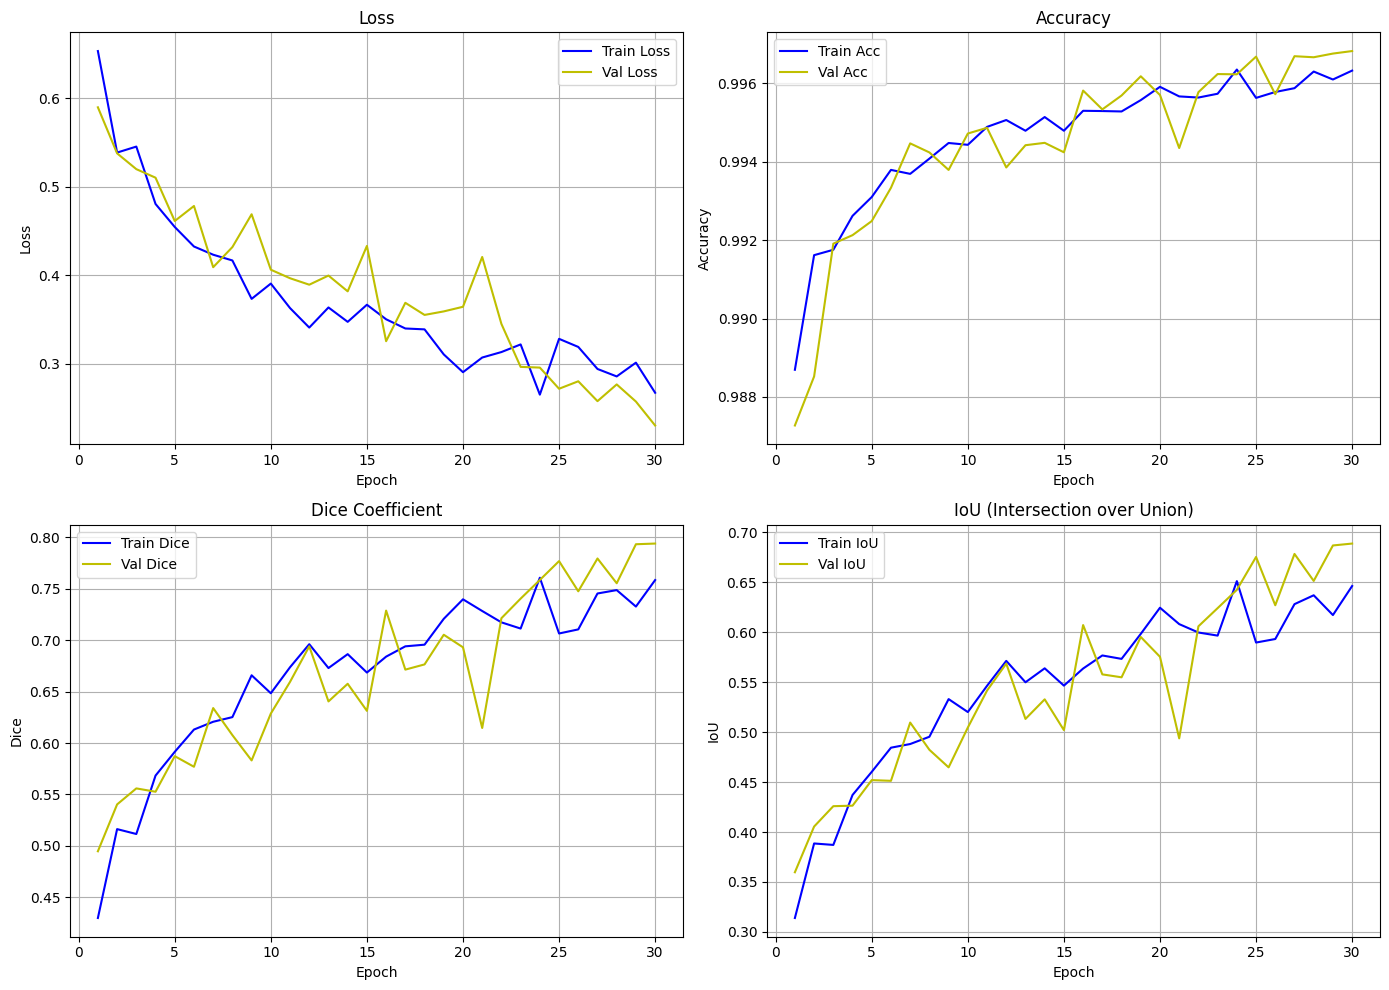

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Valeurs extraites ----
epochs = np.arange(1, 31)  # 12 epochs

# ---- Tracé ----
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'y-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Acc')
plt.plot(epochs, val_accuracies, 'y-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(epochs, train_dices, 'b-', label='Train Dice')
plt.plot(epochs, val_dices, 'y-', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(epochs, train_ious, 'b-', label='Train IoU')
plt.plot(epochs, val_ious, 'y-', label='Val IoU')
plt.title('IoU (Intersection over Union)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

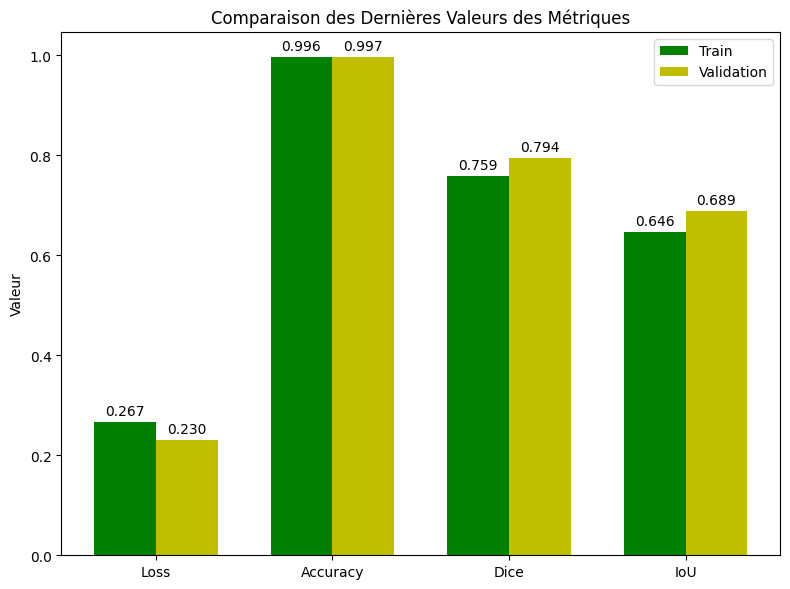

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dernières valeurs (epoch 22)
metrics = ['Loss', 'Accuracy', 'Dice', 'IoU']
#train_values = [0.3039, 0.9957, 0.7280, 0.6088]
#val_values   = [0.2843, 0.9958, 0.7458, 0.6286]
train_values = [train_losses[-1], train_accuracies[-1], train_dices[-1], train_ious[-1]]
val_values   = [val_losses[-1], val_accuracies[-1], val_dices[-1], val_ious[-1]]

x = np.arange(len(metrics))
bar_width = 0.35

plt.figure(figsize=(8,6))
bars_train = plt.bar(x - bar_width/2, train_values, bar_width, label='Train', color='g')
bars_val = plt.bar(x + bar_width/2, val_values, bar_width, label='Validation', color='y')
plt.xticks(x, metrics)
plt.ylabel('Valeur')
plt.title('Comparaison des Dernières Valeurs des Métriques')
plt.legend()
plt.tight_layout()

# Afficher la valeur au-dessus de chaque barre
for bar in bars_train:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Décalage vertical de 3 points
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10, color='black')

for bar in bars_val:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10, color='black')

plt.show()

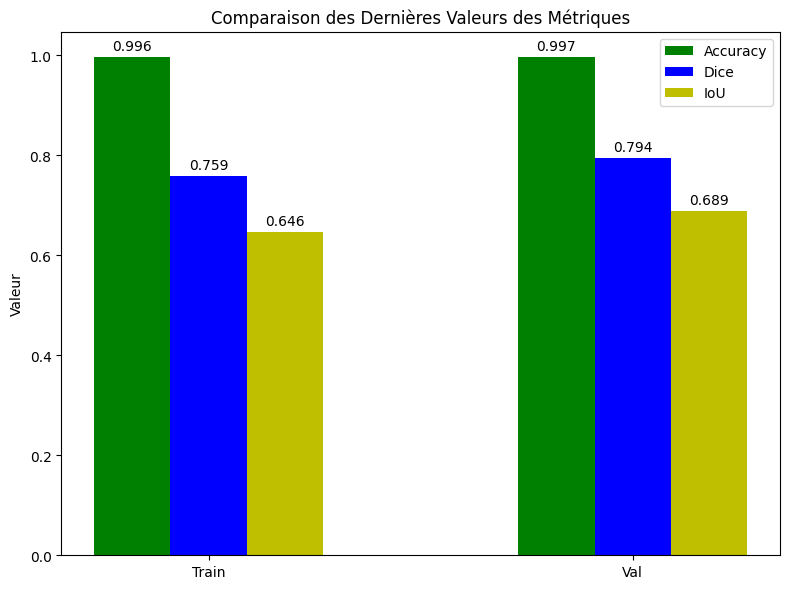

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dernières valeurs (epoch 22)
step = ['Train', 'Val']
acc = [train_accuracies[-1], val_accuracies[-1]]
dice = [train_dices[-1], val_dices[-1]]
iou = [train_ious[-1], val_ious[-1]]

metrics = ['Accuracy', 'Dice', 'IoU']
values = [acc, dice, iou]
colors = ['g' ,'b', 'y']

x = np.arange(len(step))  # [0, 1]
bar_width = 0.18

plt.figure(figsize=(8,6))

bars = []
for i, (vals, metric, color) in enumerate(zip(values, metrics, colors)):
    bar = plt.bar(x + (i-1)*bar_width, vals, bar_width, label=metric, color=color)
    bars.append(bar)

plt.xticks(x, step)
plt.ylabel('Valeur')
plt.title('Comparaison des Dernières Valeurs des Métriques')
plt.legend()
plt.tight_layout()

# Afficher les valeurs en haut des barres
for group in bars:
    for bar in group:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3),  # Décalage vertical
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, color='black')

plt.show()

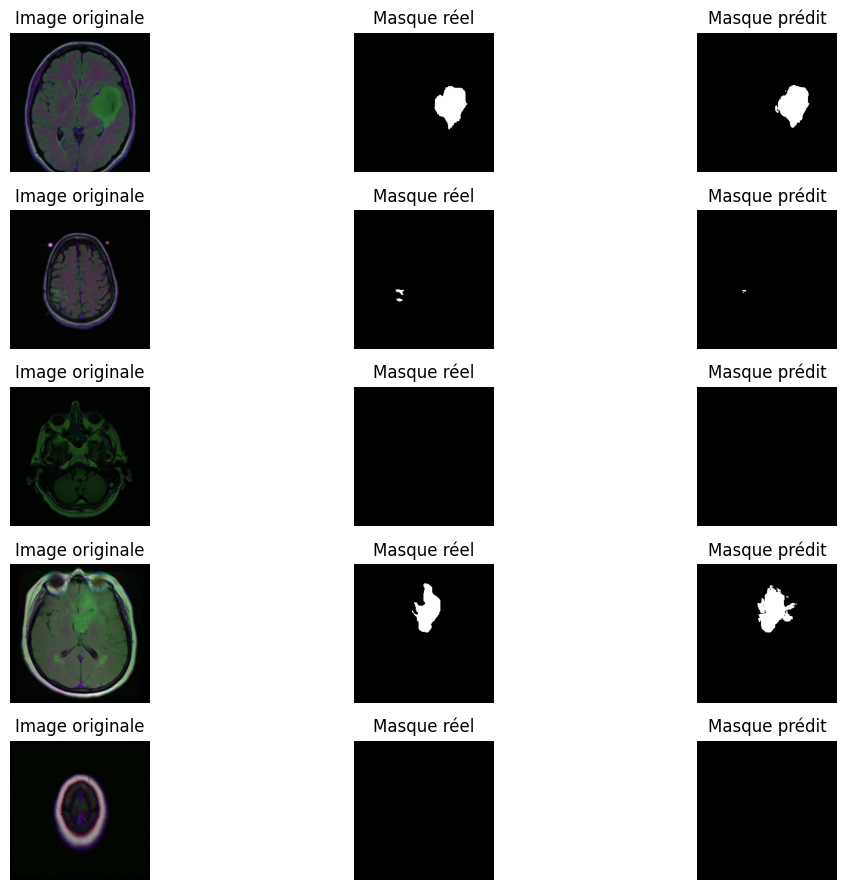

In [ ]:
import torch
import matplotlib.pyplot as plt

model.eval()  # Mettre le modèle en mode évaluation

# Prendre un batch du dataloader de validation
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()  # Binarisation

# Conversion pour affichage
images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy()
preds_np = preds.cpu().numpy()

# Afficher 5 premiers exemples
plt.figure(figsize=(12, 9))
for i in range(5):
    # Image originale
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(images_np[i].transpose(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Image originale")
    plt.axis("off")

    # Masque réel
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(masks_np[i].squeeze(), cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

    # Masque prédit
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(preds_np[i].squeeze(), cmap="gray")
    plt.title("Masque prédit")
    plt.axis("off")

plt.tight_layout()
plt.show()
